# Assignment — Deep Recurrent Graph Generation

### Task 1. Recurrent attention GNN (1 point)

In [1]:
#!pip install dgl -f https://data.dgl.ai/wheels/repo.html -q
!pip install dgl-cu113 -f https://data.dgl.ai/wheels/repo.html -q
import dgl
dgl.__version__

     |████████████████████████████████| 152.9 MB 29 kB/s 
Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


DGL backend not selected or invalid.  Assuming PyTorch for now.
Using backend: pytorch


'0.7.2'

In [2]:
import dgl
import dgl.nn as dnn
import dgl.function as fn
from dgl.data import DGLDataset, GINDataset

import torch
import torch.nn as nn
import torch.distributions as D
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader, Subset

import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import ks_2samp

from tqdm.notebook import trange, tqdm
import requests

In [3]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

The traditional graph generation approaches (Erdos-Renyi, Barabasi-Albert, etc.) can be used to efficiently generate synthetic graphs that have certain properties. Such models can give us insight into how certain graph structures might arise in the real world. However, they rely on a fixed, handcrafted generation process. On the other side, deep generation approaches will seek to learn a generative model on a set of training graphs. This assignment is dedicated to a such generative model inspired by GRAN [Liao et al., 2019](https://arxiv.org/pdf/1910.00760.pdf). 

The idea of the model is to generate a graph by adding nodes one-by-one. Features of existing nodes are fed into a recurrent attention GNN for creating node embedding. Then the embeddings used for estimating parameters of Bernoulli distributions that can model probabilities of new edges. First, let us create a recurrent attention model for node embedding. Each layer in the network takes a graph with node states $h^l$ and propagate them as follows:

$$h^{l+1}_i = \text{GRU}\left(h^l_i, \sum_{j\in\mathcal{N}(i)} a_{ij}^l m_{ij}^l\right)$$
$$m_{ij}^l = f(h_i^l - h_j^l)$$
$$a_{ij}^l = g(h_i^l - h_j^l)$$

where $\mathcal{N}(i)$ is a neighborhood of the node $i$, $f(\cdot)$ is the message function, $g(\cdot)$ is the attention head (both are two-layer MLP). The initial node states are node features. The node embeddings are final node states.

Write a function `_prop` that takes a graph, node states, index of a layer and propagate current node states, returns next node states.

*Hints:* 
* *apply the DGL message passing framework*
* *`fn.u_sub_v` for creating messages — difference between adjacent node states*
* *`graph.apply_edges` for storing the messages into edge features*
* *`graph.update_all` for reduction messages from adjacent edges (summation in this task)*

In [4]:
class RecurrentGNN(nn.Module):
    def __init__(self, node_state_dim, hid_dim, num_layer):
        super().__init__()
        self.num_layer = num_layer
        self.update_func = nn.ModuleList([
            nn.GRUCell(input_size=hid_dim, hidden_size=node_state_dim) 
            for _ in range(self.num_layer)
        ])
        self.msg_func = nn.ModuleList([
            nn.Sequential(
                *[
                    nn.Linear(node_state_dim, hid_dim),
                    nn.ReLU(),
                    nn.Linear(hid_dim, hid_dim)
                ]) for _ in range(self.num_layer)
        ])
        self.att_head = nn.ModuleList([
            nn.Sequential(
                *[
                    nn.Linear(node_state_dim, hid_dim),
                    nn.ReLU(),
                    nn.Linear(hid_dim, hid_dim),
                    nn.Sigmoid()
                ]) for _ in range(self.num_layer)
        ])

    def _prop(self, graph, state, layer_idx=0):
        #graph = graph.to(device)
        #state = state.to(device)
        graph.ndata['state'] = state
        graph.apply_edges(fn.u_sub_v('state', 'state', 'sub'))

        graph.edata['f'] = self.msg_func[layer_idx](graph.edata['sub'])
        graph.edata['g'] = self.att_head[layer_idx](graph.edata['sub'])

        graph.edata['mult'] = graph.edata['f'] * graph.edata['g']    
        
        graph.update_all(fn.copy_e('mult', 'msg'), fn.sum('msg', 'res'))
            
        output = self.update_func[layer_idx](graph.ndata['res'], graph.ndata['state'])

        return output

    def forward(self, graph, feat):
        state = feat
        for i in range(self.num_layer):
            if i > 0:
                state = F.relu(state)
            state = self._prop(graph, state, layer_idx=i)
        return state

In [5]:
torch.manual_seed(0)
model = RecurrentGNN(node_state_dim=16, hid_dim=128, num_layer=5)
graph = dgl.from_networkx(nx.grid_2d_graph(2, 2))
feat = torch.ones(4, 16)
out = model._prop(graph, feat, layer_idx=0)
assert out.shape == (4, 16)
test_ans = out.detach().numpy()[0, :3].round(2)
assert np.all(np.isclose(test_ans, [0.68, 0.57, 0.29]))
out = model._prop(graph, feat, layer_idx=1)
test_ans = out.detach().numpy()[0, :3].round(2)
assert np.all(np.isclose(test_ans, [0.66, 0.45, 0.72]))

### Task 2. Bernoulli probabilistic model (1 point)

Next, the generation process is performed as follows: 
1. Start from a graph with a single node
2. Produce parameters of the distributions based on graph
3. Add new node to the graph and sample edges from new node using the distributions
4. Repeat steps 2-3 to the desired number of nodes

<img src='https://raw.githubusercontent.com/netspractice/advanced_gnn/main/assignment_recurrent_generation/gnn_generation.png' width=600>

For example, we have the graph with 4 nodes, we produce 4 parameters of 4 independent Bernoulli distributions, and then sample 4 boolean values. Let it be (0, 0, 1, 1), then we connect the new node to the third and fourth nodes. In this assignment, let us use MLP for converting node embeddings into 1-dimensional parameters of Bernoulli distributions.

Write a class `BernoulliGNN`. The network takes a graph and node features, propagate them through a recurrent GNN, then through a two-layer MLP and returns parameters of distributions.

In [36]:
class BernoulliGNN(nn.Module):
    def __init__(self, in_dim, hid_dim, num_layer):
        super().__init__()
        self.hid_dim = hid_dim
        self.gru = RecurrentGNN(node_state_dim=in_dim, hid_dim=hid_dim, num_layer=num_layer)
        self.mlp = nn.Sequential(nn.Linear(in_dim, in_dim), 
                                 nn.Linear(in_dim, 1), 
                                 nn.Sigmoid()
                                )
        
    def forward(self, graph, feat):
        eps = 10e-5
        x = self.gru(graph.to(device), feat.to(device))
        out = torch.clamp(self.mlp(x), min=0. + eps, max=1. - eps)       
        
        return out

In [37]:
model = BernoulliGNN(in_dim=16, hid_dim=128, num_layer=5)
graph = dgl.from_networkx(nx.grid_2d_graph(2, 2))
feat = torch.ones(4, 16)
theta = model(graph, feat)
assert theta.shape == (4, 1)
assert torch.all((0 <= theta) & (theta <= 1))

RuntimeError: ignored

Write a function `sample` that takes parameters `theta` and returns realization from corresponding Bernoulli distributions.

In [38]:
def sample(theta):
    return torch.bernoulli(theta)
    #res = theta > 0.5

    #return res.to(torch.long)

In [39]:
theta = torch.tensor([[0.999], [0.001], [0.999], [0.999]])
assert torch.all(sample(theta) == torch.tensor([[1], [0], [1], [1]]))

### Task 3. Generation process (1 point)

Let us check what we can generate using an untrained model. Let the node features be one-hot encoded vector with node index. The node features dimension can be larger than the number of nodes, so let it be padded with zeros on the right. For example, 6-dimensional node features in a graph with 4 nodes be:

$$F = \begin{pmatrix}
1 & 0 & 0 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 & 0 & 0 \\
0 & 0 & 1 & 0 & 0 & 0 \\
0 & 0 & 0 & 1 & 0 & 0 \\
\end{pmatrix}$$


Write a function `generate_graph` that takes a model, number of nodes, node features dimension and returns a generated graph and node features. The generated graph is undirected and contains self-loops.

In [15]:
def generate_graph(model, n_nodes, feat_dim):
    # starting from a graph with a single node
    feat = torch.zeros(1, feat_dim).to(device)
    feat[0, 0] = 1
    graph = dgl.graph(data=([0], [0])).to(device)
    for i in range(1, n_nodes):
        nodes = graph.nodes()
        src_nodes, dst_nodes = graph.edges()
        theta = model(graph, feat.to(device)).to(device)
        new_edges = sample(theta).to(torch.bool).squeeze()
        
        new_src_nodes = nodes[new_edges]
        
        new_src_nodes = torch.cat((new_src_nodes.view(-1), torch.tensor([i]).to(device)))
        src_nodes = torch.cat((src_nodes, new_src_nodes)).squeeze()
        
        new_dst_nodes = torch.tensor([i] * new_src_nodes.shape[0]).to(device)
        dst_nodes = torch.cat((dst_nodes, new_dst_nodes))
        
        src_nodes = torch.cat((src_nodes, new_dst_nodes[:-1]))
        dst_nodes = torch.cat((dst_nodes, new_src_nodes[:-1]))
        
        graph = dgl.graph(data=(src_nodes, dst_nodes)).to(device)
        
        pad_with = feat_dim - graph.number_of_nodes()
        feat = F.pad(torch.diag(torch.ones(graph.number_of_nodes())), (0, pad_with), 'constant', 0)
                
    return graph, feat

In [21]:
model = BernoulliGNN(in_dim=16, hid_dim=128, num_layer=5)
model = model.to(device)
graph, feat = generate_graph(model, n_nodes=16, feat_dim=16)
graph, feat = graph.cpu(), feat.cpu()

In [22]:
model = BernoulliGNN(in_dim=16, hid_dim=128, num_layer=5)
model = model.to(device)
graph, feat = generate_graph(model, n_nodes=16, feat_dim=16)
graph, feat = graph.cpu(), feat.cpu()

assert graph.number_of_nodes() == 16
assert graph.number_of_edges() > 1
assert feat.shape == (16, 16)
assert torch.all(feat[:3, :3] == torch.tensor([[1, 0, 0], [0, 1, 0], [0, 0, 1]]))
adj = graph.adj().to_dense()
assert torch.all(adj[range(10), range(10)] == 1)
assert torch.all(adj == adj.t())

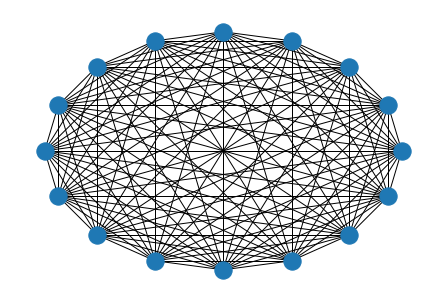

In [23]:
G = nx.Graph(graph.to_networkx())
G.remove_edges_from(nx.selfloop_edges(G))
nx.draw_kamada_kawai(G)

### Task 4. Negative log likelihood loss (1 point)

We aim to train the model so that it can be able to generate realistic networks. Fortunately, explicit parametric models can be optimized by maximim likelihood estimation. In torch, it can be performed by minimization negative log likelihood loss.

Write a function `bernoulli_nll` that takes parameters `theta` and a realization `label`, returns the mean negative log likelihood.

In [16]:
def bernoulli_nll(theta, label):
    theta = theta.to(device)
    label = label.to(device)
    return -(torch.log(theta) * label + torch.log(1 - theta) * (1 - label)).mean()

In [25]:
theta = torch.tensor([[0.999], [0.001], [0.999], [0.999]])
label = torch.tensor([[1.], [0.], [1.], [1.]])
loss1 = bernoulli_nll(theta, label)
label = torch.tensor([[1.], [0.], [0.], [1.]])
loss2 = bernoulli_nll(theta, label)
label = torch.tensor([[0.], [1.], [0.], [0.]])
loss3 = bernoulli_nll(theta, label)
assert loss1 < loss2 < loss3

### Task 5. Dataloader for grid subgraphs (1 point)

Let us train the model to generate 2d grid graphs, it can be useful for visual verification of the model. The auxiliary function `grid_graphs` generates grid graphs with one-hot encoded node features and returns a list of DGL graphs.

In [17]:
def grid_graphs(min_dim, max_dim, n_graphs, feat_dim):
    graphs = []
    for i in range(n_graphs):
        i = np.random.randint(min_dim, max_dim + 1)
        j = np.random.randint(min_dim, max_dim + 1)
        G = nx.grid_2d_graph(i, j)
        graph = dgl.from_networkx(G)
        graph = graph.add_self_loop()
        feat = torch.eye(graph.number_of_nodes())
        feat = F.pad(feat, [0, feat_dim - graph.number_of_nodes(), 0, 0])
        graph.ndata['feat'] = feat
        graphs.append(graph)
    return graphs

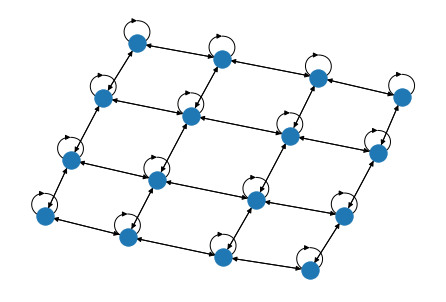

In [ ]:
nx.draw(grid_graphs(4, 4, 1, 16)[0].to_networkx())

Next, we need to define the train dataset where graphs are subgraphs from initial grid graphs and labels are next node indicator vectors. For a given graph, the label defines connections to the next node. For example, let the left depicted graph be a subgraph and the next node be 5, then a label be a column-vector `[[0], [0], [1], [1]]`.

<img src='https://raw.githubusercontent.com/netspractice/advanced_gnn/main/assignment_recurrent_generation/gnn_generation.png' width=600>

Write a function `process` that divides each graph into N subgraphs and prepares N labels where N is the number of nodes minus one. Then it stores all subgraphs and labels into `self.graphs` and `self.labels` lists.

For example, the dataset on the single graph with 5 nodes looks like:
* subgraph with nodes [0], label for the node 1
* subgraph with nodes [0, 1], label for the node 2
* subgraph with nodes [0, 1, 2], label for the node 3
* subgraph with nodes [0, 1, 2, 3], label for the node 4

In [18]:
class GridDataset(DGLDataset):
    def __init__(self, feat_dim, min_dim, max_dim, n_graphs):
        self.feat_dim = feat_dim
        self.min_dim = min_dim
        self.max_dim = max_dim
        self.n_graphs = n_graphs
        self.graphs = None
        self.labels = None
        super().__init__(name='grid')

    def process(self):
        graphs = []
        labels = []
        for graph in grid_graphs(self.min_dim, self.max_dim, self.n_graphs, self.feat_dim):
            adj = graph.adj().to_dense()
            for i in range(1, graph.number_of_nodes()):
                graphs.append(graph.subgraph(range(i)))
                subgraph_labels = torch.tensor([k for k in adj[:i + 1, :i][-1]]).reshape(-1, 1)
                labels.append(subgraph_labels)
        self.graphs = graphs
        self.labels = labels

    def __len__(self):
        return len(self.graphs)

    def __getitem__(self, idx):
        return self.graphs[idx], self.labels[idx]

In [28]:
feat_dim = 40
min_dim = 3
max_dim = 6
n_graphs = 100
grid_dataset = GridDataset(feat_dim, min_dim, max_dim, n_graphs)
assert n_graphs < len(grid_dataset) < n_graphs * max_dim**2
n_nodes = torch.tensor([g.number_of_nodes() for g, l in grid_dataset])
assert n_nodes.min() == 1
assert n_nodes.max() == max_dim**2 - 1
g, l = grid_dataset[1]
assert l.shape == (2, 1)
g, l = grid_dataset[2]
assert l.shape == (3, 1)
assert np.all([g.number_of_nodes() == l.shape[0] for g, l in grid_dataset])

In [29]:
len(grid_dataset)

1793

Finally, create a train dataloader.

In [19]:
def collate(sample):
    graphs, labels = map(list, zip(*sample))
    graph = dgl.batch(graphs)
    labels = torch.cat(labels)
    return graph, labels

grid_dataset = GridDataset(feat_dim=40, min_dim=4, max_dim=6, n_graphs=20)
dataloader = DataLoader(
    grid_dataset, batch_size=128, collate_fn=collate, shuffle=True)

for g, l in dataloader:
    break
len(dataloader), g.batch_num_nodes(), g.number_of_nodes(), l.shape

(4,
 tensor([ 1,  2, 16,  6,  7, 25,  5,  5,  6, 10,  5, 22, 16, 23,  5,  2, 14, 10,
         13,  4,  5, 22, 12, 10,  6, 24,  9,  1,  3,  1, 12,  2, 13, 12, 28, 17,
          8,  1,  9, 26, 19,  6, 10, 12,  6, 13,  1, 22,  1,  2, 21, 19,  7, 26,
         25,  9, 28,  2,  2, 19, 10, 21,  8, 11, 14, 15,  9, 10, 19, 10, 21,  6,
          5, 17,  8,  2, 20,  4, 15, 20, 29, 16, 25,  3, 16, 14, 20,  3,  3, 13,
         16, 22,  4, 24,  1, 11, 14,  3,  8, 17, 23, 29,  5,  9,  6, 21, 29,  5,
         12,  1,  1, 12, 13, 24,  6, 11, 25, 23, 13, 19, 21, 31,  7,  2, 14, 18,
         27, 11]),
 1593,
 torch.Size([1593, 1]))

### Task 6. Mini-batch training process (1 point)

Write a finction `train`. Here is a simple training process: calculate the NLL loss and make an optimization step.

In [20]:
def train(model, dataloader, opt):
    loss_values = []
    for graph, label in dataloader:
        opt.zero_grad()
        logits = model(graph, graph.ndata['feat'])
        loss = bernoulli_nll(logits, label)
        loss.backward()
        opt.step()
        loss_values.append(loss)
    return sum(loss_values) / len(loss_values)

In [ ]:
model = BernoulliGNN(in_dim=40, hid_dim=128, num_layer=5)
model.to(device);

The training process takes about 10 minutes in Colab on CPU and about a minute in Colab on GPU.

  0%|          | 0/500 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: 1/500, NLL loss: 0.6217


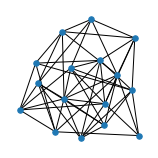

Epoch: 51/500, NLL loss: 0.0353


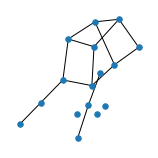

Epoch: 101/500, NLL loss: 0.0219


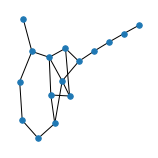

Epoch: 151/500, NLL loss: 0.0138


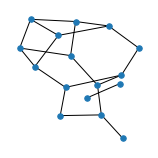

Epoch: 201/500, NLL loss: 0.0115


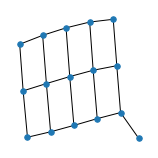

Epoch: 251/500, NLL loss: 0.0279


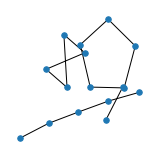

Epoch: 301/500, NLL loss: 0.0158


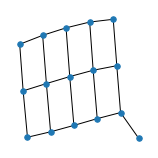

Epoch: 351/500, NLL loss: 0.0160


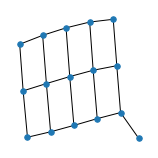

Epoch: 401/500, NLL loss: 0.0076


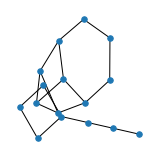

Epoch: 451/500, NLL loss: 0.0103


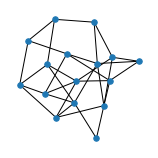

Epoch: 500/500, NLL loss: 0.0053


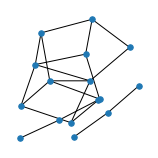

In [ ]:
opt = Adam(model.parameters(), lr=0.0005)

n_epochs = 500
for e in trange(n_epochs):
    loss = train(model, dataloader, opt)
    if e % 50 == 0 or e+1 == n_epochs:
        print(f'Epoch: {e+1}/{n_epochs}, NLL loss: {loss:.4f}')
        plt.figure(figsize=(2,2))
        graph, feat = generate_graph(model, n_nodes=16, feat_dim=40)
        G = nx.Graph(graph.cpu().to_networkx())
        G.remove_edges_from(nx.selfloop_edges(G))
        nx.draw_kamada_kawai(G, node_size=30)
        plt.show()

Let us generate a few graphs from the model. They should be visually close to grid graphs.

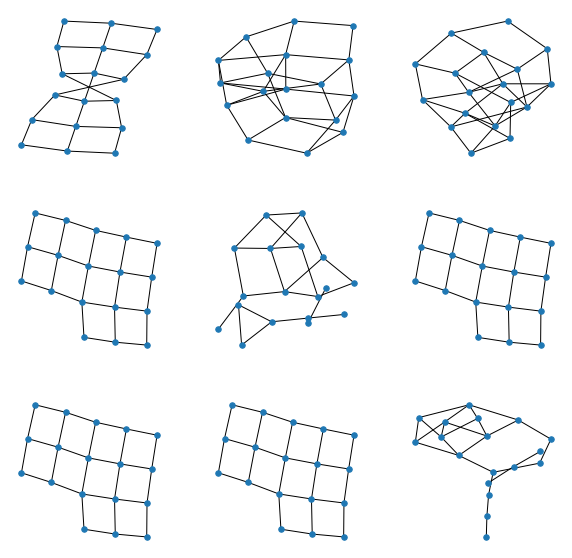

In [ ]:
plt.figure(figsize=(10, 10))
for j in range(9):
    plt.subplot(3, 3, j+1)
    graph, feat = generate_graph(model, n_nodes=18, feat_dim=40)
    G = nx.Graph(graph.cpu().to_networkx())
    G.remove_edges_from(nx.selfloop_edges(G))
    nx.draw_kamada_kawai(G, node_size=30)

The next cell checks that at least one graph in a sample is close to a grid. It is possible with approximately 0.05 NLL loss. Note that all hyperparameters can be modified to achive the desired result.

In [ ]:
close_to_grid = False
for i in range(20):
    graph, feat = generate_graph(model, n_nodes=18, feat_dim=40)
    G = nx.Graph(graph.cpu().to_networkx())
    G.remove_edges_from(nx.selfloop_edges(G))
    hist = nx.degree_histogram(G)
    correct_degrees = sum(hist[2:5])
    incorrec_degrees = sum(hist) - correct_degrees
    close_to_grid = nx.is_connected(G) and correct_degrees > 0 and incorrec_degrees == 0
    if close_to_grid: break
assert close_to_grid

### Task 7. Kolmogorov Smirnov distance score (1 point)

Let us check the model on real graphs. Let a quality metric be the closeness of generated graphs to real graphs. We will compute the sum of KS distances between distributions of statistics: clustering coefficients, laplacian spectrum values, node degrees.

Write a function `ks_score` that takes a list of real graphs, a list of generated (fake) graphs and computes the sum of KS distances. The input graphs are DGL graphs.

*Hint: use `ks_2samp`*

In [21]:
def ks_score(fake_graphs, real_graphs):
    real_graphs = [nx.Graph(g.to_networkx()) for g in real_graphs]
    fake_graphs = [nx.Graph(g.to_networkx()) for g in fake_graphs]
    
    eigen = lambda x: nx.linalg.spectrum.laplacian_spectrum(x)
    clust = lambda x: nx.algorithms.cluster.clustering(x) #lambda x: nx.algorithms.approximation.average_clustering(x)
    degre = lambda x: nx.Graph(x).degree()

    eigen_real = np.array([])
    for g in real_graphs:
      eigen_real = np.append(eigen_real, eigen(g))

    eigen_fake = np.array([])
    for g in fake_graphs:
      eigen_fake = np.append(eigen_fake, eigen(g))

    eigen_stat = ks_2samp(eigen_real, eigen_fake).statistic

    clust_real = []
    for g in real_graphs:
      clust_res = clust(g)
      clust_coef = [c[1] for c in clust_res.items()]
      clust_real += clust_coef

    clust_fake = []
    for g in fake_graphs:
      clust_res = clust(g)
      clust_coef = [c[1] for c in clust_res.items()]
      clust_fake += clust_coef

    clust_stat = ks_2samp(clust_real, clust_fake).statistic

    degre_real = []
    for g in real_graphs:
      degrees = degre(g)
      degrees = [deg[1] for deg in list(degrees)]
      degre_real += degrees

    degre_fake = []
    for g in fake_graphs:
      degrees = degre(g)
      degrees = [deg[1] for deg in list(degrees)]
      degre_fake += degrees

    degre_stat = ks_2samp(degre_real, degre_fake).statistic

    return eigen_stat + clust_stat +  degre_stat

In [33]:
rand_graph = dgl.from_networkx(nx.erdos_renyi_graph(10, 30))
grid55_graph = dgl.from_networkx(nx.grid_2d_graph(5, 5))
grid44_graph = dgl.from_networkx(nx.grid_2d_graph(4, 4))
score = ks_score([rand_graph], [grid55_graph])
assert score == 2.9
score = ks_score([grid55_graph], [grid55_graph])
assert score == 0
score = ks_score([grid55_graph], [grid44_graph])
assert score == 0.29

### Task 8. DFS from top degree node ordering (1 point)

So far, we have tested our model on grid graphs that have predefined node ordering. It helps us to train the model, but real networks are arbitrary ordered and so we need to select certain node ordering to train the model. There are many approaches: node degree, DFS/BFS from top node degree, k-core decomposition and so on. In this assignment, let us select DFS from top degree node.

Write a function `dfs_ordering` that takes a DGL graph and returns a tensor (array) of nodes where the first node is the top degree node and others are ordered by DFS from the top degree node. We assume that the graph has a single connected component.

In [22]:
def dfs_ordering(graph):
    adj = graph.adj().to_dense()
    top_degree = adj.sum(dim=1).argmax()
    dfs_seq = dgl.dfs_edges_generator(graph, top_degree)
    dst_nodes = graph.edges()[1]
    idx = [idx.numpy()[0] for idx in dfs_seq]
    ordered_nodes = torch.cat((top_degree.unsqueeze(-1), dst_nodes[idx]))
    return ordered_nodes

In [35]:
G = nx.complete_graph(5)
G.add_edges_from([[0, -1], [-1, -2], [-2, -3]])
graph = dgl.from_networkx(G)
ord = dfs_ordering(graph)
assert ord.shape == (8, )
adj = graph.adj().to_dense()
assert torch.all(adj[ord, :][:, ord][0] == torch.tensor([0, 1, 1, 1, 1, 1, 0, 0]))

### Task 9. Erdos-Renyi model baseline (1 point)

Create a simple baseline — Erdos-Renyi model.

Write a function `fit` that takes a list of DGL graphs and estimates the parameter $p$ of Erdos-Renyi model.

Write a function `sample` that generates an Erdos-Renyi graph with parameter $n$ and $p$. The output graph is DGL graph.

In [23]:
dgl.seed(14)

class ErdosRenyi():
    def __init__(self):
        self.p = None
    def fit(self, graphs):
        p_sum = []
        for graph in graphs:
          g = graph.remove_self_loop()
          n = graph.number_of_nodes()
          p_sum.append(g.adj().to_dense().sum() / (n * (n - 1)))
          self.p = sum(p_sum) / len(p_sum)
        return
    def sample(self, n):
        return dgl.from_networkx(nx.generators.random_graphs.erdos_renyi_graph(n, self.p))

In [92]:
dgl.seed(14)
graphs = [dgl.rand_graph(10, 50), dgl.rand_graph(20, 100)]
er_model = ErdosRenyi()
er_model.fit(graphs)
assert er_model.p == (0.5 + 0.25) / 2
er_graph = er_model.sample(10)
assert 24 < er_graph.number_of_edges() < 51

### Task 10. Results on protein dataset (1 point)

In [25]:
proteins_dataset = GINDataset('PROTEINS', self_loop=True)
len(proteins_dataset)

Extracting file to /root/.dgl/GINDataset


1113

Let us test our model on proteins dataset. We will only learn small graphs for simplicity. Also we drops graph with multiple connected components.

In [26]:
proteins_dataset = GINDataset('PROTEINS', self_loop=True)
small_graphs_idx = []
for i in range(len(proteins_dataset)):
    graph = proteins_dataset.graphs[i]
    if graph.number_of_nodes() <= 40:
        n_nodes = len(torch.cat(dgl.bfs_nodes_generator(graph, 0)))
        if graph.number_of_nodes() == n_nodes:
            small_graphs_idx.append(i)
proteins_dataset = Subset(proteins_dataset, small_graphs_idx)
len(proteins_dataset)

777

Let us split the dataset into a train and test sets. We will use the train set to train the model and use the test set to calculate KS distance score between real and fake graphs. Let the train ratio be approximately 0.3.

In [27]:
torch.manual_seed(0)
train_mask = torch.rand(len(proteins_dataset)) < 0.3
train_idx = torch.where(train_mask)[0]
train_proteins_set = Subset(proteins_dataset, train_idx)
test_idx = torch.where(~train_mask)[0]
test_proteins_set = Subset(proteins_dataset, test_idx)
len(train_proteins_set), len(test_proteins_set)

(244, 533)

Check that train and test are close with respect to KS distanse score.

In [28]:
_train = [g for g, l in train_proteins_set]
_test = [g for g, l in test_proteins_set]
print(f'KS score: {ks_score(_train, _test):.4f}')

KS score: 0.0461


Also we want to learn distribution of number of nodes to generate graphs with different number of nodes.

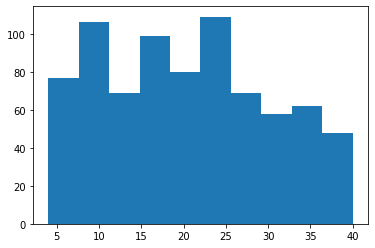

In [29]:
n_nodes_seq = [g.number_of_nodes() for g, l in proteins_dataset]
plt.hist(n_nodes_seq);

Generate graphs from Erdos Renyi model.

In [30]:
fake_graphs = [er_model.sample(np.random.choice(n_nodes_seq)) for _ in range(100)]
print(f'KS score: {ks_score(fake_graphs, _test):.4f}')

KS score: 1.7444


Next, prepare the dataset for the GNN model (similar to the grid dataset).

In [31]:
class GraphDataset(DGLDataset):
    def __init__(self, initial_set, feat_dim):
        self.initial_set = initial_set
        self.feat_dim = feat_dim
        self.graphs = None
        self.labels = None
        super().__init__(name='grid')

    def process(self):
        graphs = []
        labels = []
        for graph in self.initial_set:
            ord = dfs_ordering(graph)
            graph = dgl.reorder_graph(
                graph, 'custom', permute_config={'nodes_perm':ord})
            feat = torch.eye(graph.number_of_nodes())
            feat = F.pad(feat, [0, self.feat_dim - graph.number_of_nodes(), 0, 0])
            graph.ndata['feat'] = feat
            
            adj = graph.adj().to_dense()
            for i in range(1, graph.number_of_nodes()):
                graphs.append(graph.subgraph(range(i)))
                subgraph_labels = torch.tensor([k for k in adj[:i + 1, :i][-1]]).reshape(-1, 1)
                labels.append(subgraph_labels)
        self.graphs = graphs
        self.labels = labels


        self.graphs = graphs
        self.labels = labels

    def __len__(self):
        return len(self.graphs)

    def __getitem__(self, idx):
        return self.graphs[idx], self.labels[idx]

In [32]:
graph_dataset = GraphDataset(_train, feat_dim=40)
assert len(graph_dataset) == 4701

In [33]:
dataloader = DataLoader(
    graph_dataset, batch_size=512, collate_fn=collate, shuffle=True)
len(dataloader)

10

Train the model. To pass time limits, load the model parameters using loading Torch interface: https://pytorch.org/tutorials/beginner/saving_loading_models.html. There is also a way to speed the training process using iterations over blocks of nodes (details are in [Liao et al., 2019](https://arxiv.org/pdf/1910.00760.pdf)). In this assignment, the block size is 1 for simplicity.

In [64]:
def train_on_proteins(dataloader):
    # YOUR CODE HERE
    model = BernoulliGNN(in_dim=40, hid_dim=128, num_layer=5)
    model.to(device);
    url = 'https://github.com/AlexShevchuk7/MADE/blob/master/Graphs%20NN/BernoulliGNN_proteins.pkl?raw=true'
    open('model.pkl', 'wb').write(requests.get(url).content)
    model.load_state_dict(torch.load('model.pkl'))
    return model

    model = BernoulliGNN(in_dim=40, hid_dim=128, num_layer=5)
    model.to(device);
    opt = Adam(model.parameters(), lr=0.0005)
    n_epochs = 1000
    for e in trange(n_epochs):
        loss = train(model, dataloader, opt)
        if e % 50 == 0 or e+1 == n_epochs:
            print(f'Epoch: {e+1}/{n_epochs}, NLL loss: {loss:.4f}')
            plt.figure(figsize=(2,2))
            graph, feat = generate_graph(model, n_nodes=30, feat_dim=40)
            G = nx.Graph(graph.cpu().to_networkx())
            G.remove_edges_from(nx.selfloop_edges(G))
            nx.draw_kamada_kawai(G, node_size=30)
            plt.show()
    return model

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch: 1/1000, NLL loss: 0.6018


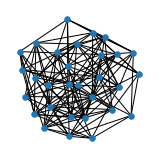

Epoch: 51/1000, NLL loss: 0.2235


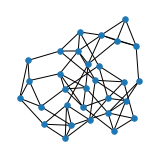

Epoch: 101/1000, NLL loss: 0.1952


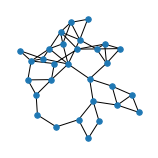

Epoch: 151/1000, NLL loss: 0.1772


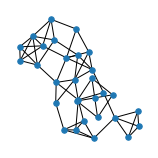

Epoch: 201/1000, NLL loss: 0.1535


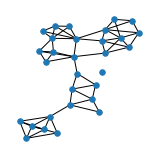

Epoch: 251/1000, NLL loss: 0.1299


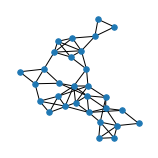

Epoch: 301/1000, NLL loss: 0.1154


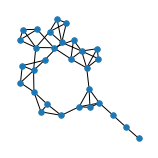

Epoch: 351/1000, NLL loss: 0.1061


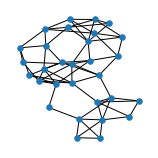

Epoch: 401/1000, NLL loss: 0.0946


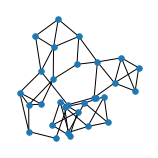

Epoch: 451/1000, NLL loss: 0.0878


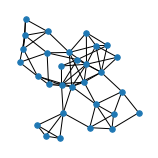

Epoch: 501/1000, NLL loss: 0.0846


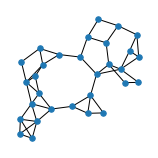

Epoch: 551/1000, NLL loss: 0.0826


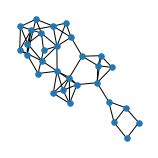

Epoch: 601/1000, NLL loss: 0.0793


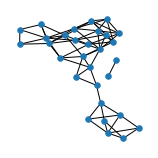

Epoch: 651/1000, NLL loss: 0.0779


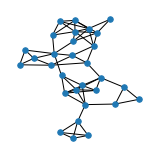

Epoch: 701/1000, NLL loss: 0.0751


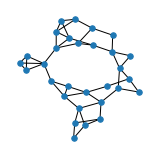

Epoch: 751/1000, NLL loss: 0.0673


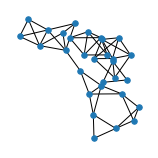

Epoch: 801/1000, NLL loss: 0.0691


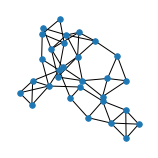

Epoch: 851/1000, NLL loss: 0.0680


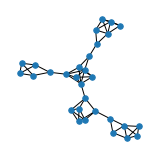

Epoch: 901/1000, NLL loss: 0.0657


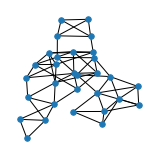

Epoch: 951/1000, NLL loss: 0.0637


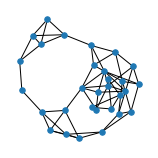

Epoch: 1000/1000, NLL loss: 0.0694


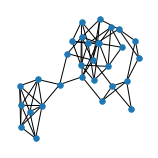

  0%|          | 0/100 [00:00<?, ?it/s]

In [40]:
model = train_on_proteins(dataloader)
fake_graphs = []
for _ in range(100):
    graph = er_model.sample(np.random.choice(n_nodes_seq))
    fake_graphs.append(graph)
er_score = ks_score(fake_graphs, _test)

fake_graphs = []
feat_dim = 40
for _ in trange(100):
    graph, feat = generate_graph(model, np.random.choice(n_nodes_seq), feat_dim)
    fake_graphs.append(graph.cpu())
gnn_score = ks_score(fake_graphs, _test)

assert gnn_score < er_score
assert gnn_score < 1

In [41]:
print(f'Erdos Renyi KS score: {er_score:.4f}')
print(f'GNN model KS score: {gnn_score:.4f}')

Erdos Renyi KS score: 1.5475
GNN model KS score: 0.1940


In [44]:
torch.save(model.state_dict(), 'BernoulliGNN.pkl')

Examples of real graphs

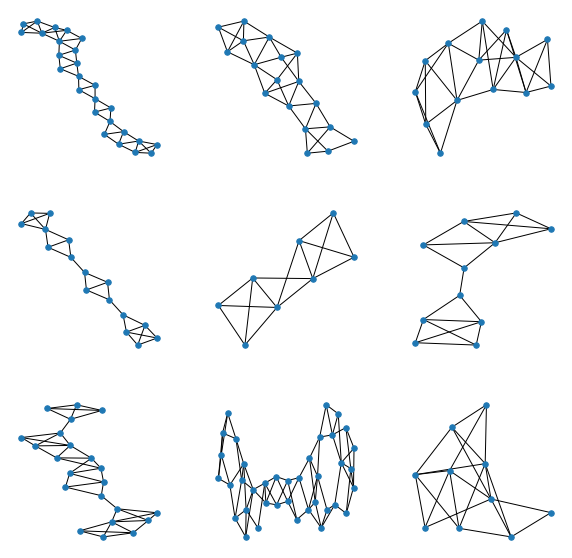

In [45]:
plt.figure(figsize=(10, 10))
for j in range(9):
    plt.subplot(3, 3, j+1)
    graph = np.random.choice(_test)
    G = nx.Graph(graph.cpu().to_networkx())
    G.remove_edges_from(nx.selfloop_edges(G))
    nx.draw_kamada_kawai(G, node_size=30)

Examples of fake graphs

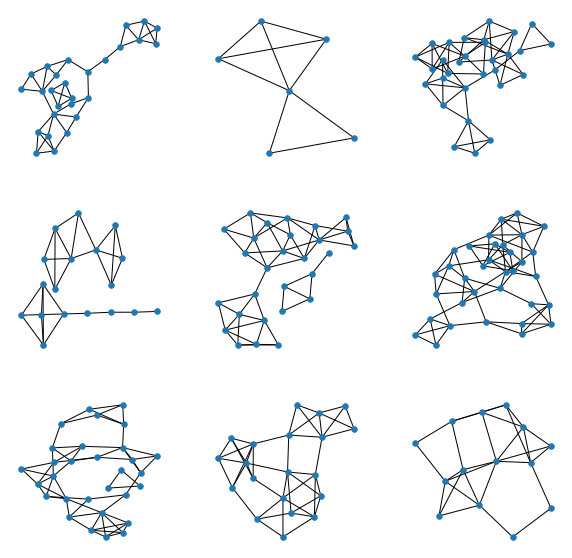

In [46]:
plt.figure(figsize=(10, 10))
for j in range(9):
    plt.subplot(3, 3, j+1)
    graph, feat = generate_graph(model, n_nodes=np.random.choice(n_nodes_seq), feat_dim=40)
    G = nx.Graph(graph.cpu().to_networkx())
    G.remove_edges_from(nx.selfloop_edges(G))
    nx.draw_kamada_kawai(G, node_size=30)